In [48]:
import os
import gc
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from zillow.dataclasses.data_wrangling import WranglingColumnsConfig
from zillow.config.feature_engineering import FeaturesDtypeConversionConfig_v1
from zillow.utils.common import (read_data, find_shared_cols, find_unshared_cols, 
        get_feat_nature_types, throw_col_not_exist_warning, modify_dataclass,
        get_obj_features)
from zillow.config.config import load_config_no_wrap, create_config_from_dict, merge_configs
from zillow.config.paths import PROCESSED_DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, REPORTS_DIR, ANALYSIS_RESULTS_DIR
from zillow.features.cleaning import clip_values_based_cfg, handle_cat_and_missing_quick

cfg = load_config_no_wrap('default')
cur_cfg = create_config_from_dict({
    'load_all_data': False,
    'n_top_cols': 10,
    'main_train_path': INTERIM_DATA_DIR / 'train_train_2016_cleaned_v1.parquet',
})
cfg = merge_configs(cfg, cur_cfg)

np.random.seed(cfg.RSEED)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
pd.set_option('display.max_columns', None)

zillow_dictionary = pd.read_csv(RAW_DATA_DIR / "zillow_data_dictionary.csv")

if cfg.to_load_all_data:
    properties_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2016_v1.0.parquet", dtype='default')
    properties_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_properties_2017_v1.0.parquet", dtype='default')
    train_2016 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2016_v1.0.parquet", dtype='default')
    train_2017 = read_data(path=INTERIM_DATA_DIR / "cleaned_train_2017_v1.0.parquet", dtype='default')

train = read_data(cfg.main_train_path, dtype='default')

wrangling_cols_cfg = WranglingColumnsConfig()
features_dtype_cfg = FeaturesDtypeConversionConfig_v1()


In [38]:
feats_types = get_feat_nature_types(train)

columns_numeric = feats_types['numeric_features']
columns_categorical = feats_types['categorical_features']
columns_boolean = feats_types['boolean_features']

#### Plotting

In [4]:
def plot_numeric_and_target(data, col, ax=None):
    """
    Plots the distribution of a numeric col and its correlation with the target variable.
    """
    if col not in data.columns:
        throw_col_not_exist_warning(col)
        return

    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(data[col], kde=True, ax=ax[0])
    ax[0].set_title(f'Distribution of {col}')
    
    sns.scatterplot(x=data[col], y=data[cfg.target], ax=ax[1], alpha=0.2)
    ax[1].set_title(f'{col} vs {cfg.target}')
    # qq How to force a column to be on interval from -5 to 5
    ax[1].set_ylim(-5, 5)
    
    plt.show()

def plot_categorical_and_target(data, col, ax=None):
    """
    Plots the distribution of a categorical col and its correlation with the target variable.
    """
    if col not in data.columns:
        throw_col_not_exist_warning(col)
        return
    
    max_nunique = 10
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    uni_values = data[col].value_counts().sort_values(ascending=False).head(max_nunique).index
    temp_data = data.loc[data[col].isin(uni_values), [col, cfg.target]]

    # qq How to set the order of categories in plots? Which plots have it?
    # Order is also needed to control number xticks labels.
    sns.countplot(x=temp_data[col], order=uni_values, ax=ax[0])
    ax[0].set_title(f'Distribution of {col}')

    # dropna required to categories not in uni_values
    aggregated_cat_mean = temp_data.groupby(col, observed=False).agg({
        cfg.target: 'mean'
    }).dropna()

    sns.boxplot(x=temp_data[col], y=temp_data[cfg.target], order=uni_values, ax=ax[1])
    
    # qq How to set width of the line for lineplot?
    sns.lineplot(x=ax[1].get_xticks(), y=aggregated_cat_mean[cfg.target], color='r', linewidth=2, ax=ax[1])
    ax[1].set_title(f'{col} vs {cfg.target}')
    ax[1].set_ylim(-5, 5)

    plt.show()

They are simply ordinal columns. airconditioningtypeid with, architecturalstyletypeid with, bathroomcnt, bedroomcnt, buildingqualitytypeid with, calculatedbathnbr, fullbathcnt, garagecnt, heatingorsystemtypeid, roomcnt, propertylandusetypeid with, threquarterbathnbr, unitcnt, numerofstories with, taxdelinquencyyear 

In [ ]:
clip_cols_cfg = wrangling_cols_cfg.clip_columns
small = clip_cols_cfg.small + ['parcelid']
mod = clip_cols_cfg.moderate
extreme = clip_cols_cfg.extreme

clip_cols_cfg = modify_dataclass(clip_cols_cfg, small=small, moderate=mod, extreme=extreme)
clipped_train = clip_values_based_cfg(train, clip_cols_cfg)

for col in columns_numeric:
    plot_numeric_and_target(clipped_train, col)

for col in np.concatenate([columns_categorical, columns_boolean]):
    plot_categorical_and_target(train, col)

### Computational

In [50]:
X, y = train.drop(columns=[cfg.target]), train[cfg.target]

models = [
    LogisticRegression(max_iter=300, random_state=cfg.RSEED),
    RandomForestRegressor(random_state=cfg.RSEED),
    LGBMRegressor(random_state=cfg.RSEED, verbose=-1),
    XGBRegressor(random_state=cfg.RSEED, enable_categorical=True)  
]
results = {}

columns_object = get_obj_features(X)
discrete_features_with_obj = np.concatenate([columns_categorical, columns_boolean])

#### Mutual Scores

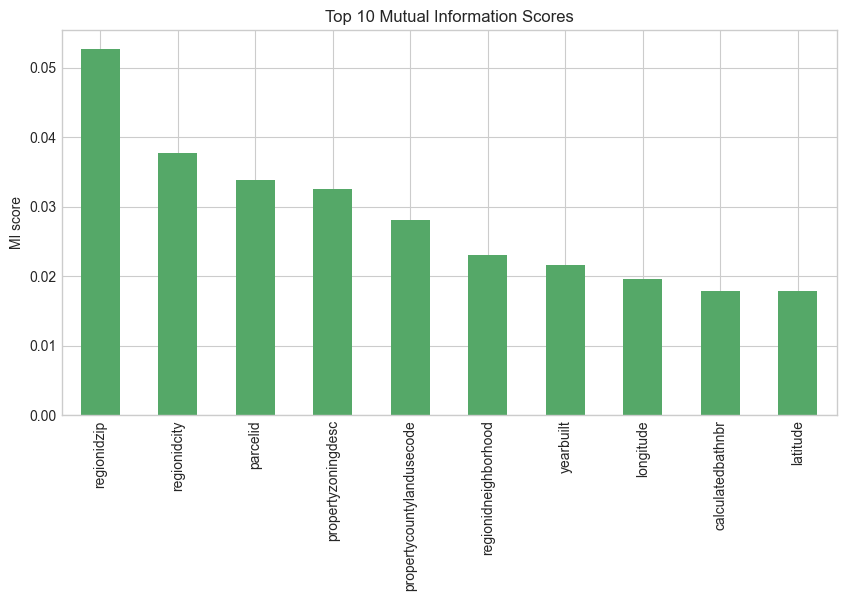

In [51]:
mi_X = handle_cat_and_missing_quick(X)
mi = mutual_info_regression(mi_X, y, random_state=cfg.RSEED, 
                            discrete_features=mi_X.columns.isin(discrete_features_with_obj))
mi_series = pd.Series(mi, index=mi_X.columns).sort_values(ascending=False)

top_mi = mi_series.head(cfg.n_top_cols)
fig, ax = plt.subplots(figsize=(10,5))
top_mi.plot(kind='bar', ax=ax, color='C2')
ax.set_title(f"Top {cfg.n_top_cols} Mutual Information Scores")
ax.set_ylabel("MI score")
plt.show()

#### Models Importances

In [ ]:
for model in models:
    model_title = model.__class__.__name__
    try:
        model.fit(X, y)
    except Exception as e:
        print(model_title, e)
        continue
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        raise ValueError(f"Model {model_title} does not have feature importances or coefficients.")
    
    results[model_title] = pd.Series(importances, index=X.columns)

models_feat_importances_df = pd.DataFrame(results)

LogisticRegression Cannot cast object dtype to float64
RandomForestRegressor Cannot cast object dtype to float32
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9135
[LightGBM] [Info] Number of data points in the train set: 81511, number of used features: 62
[LightGBM] [Info] Start training from score 0.010967


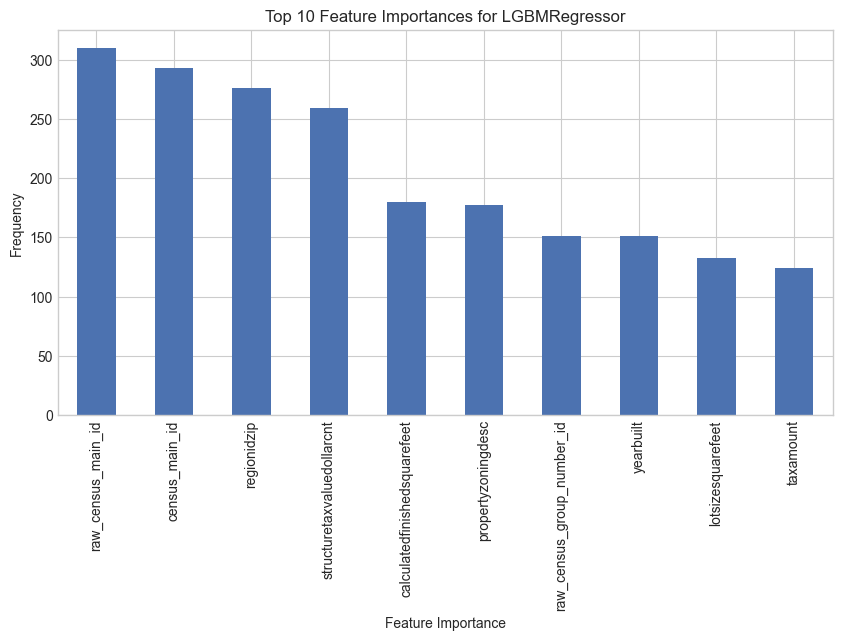

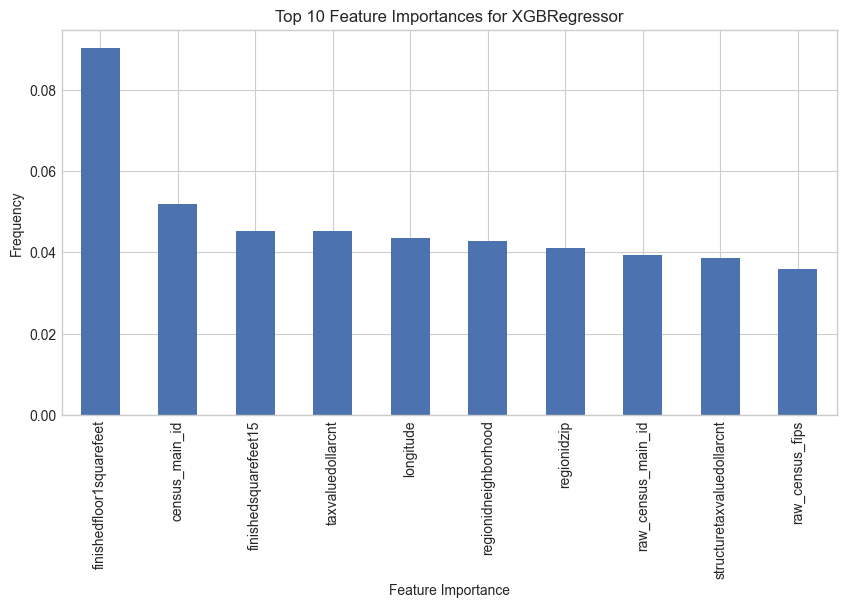

['raw_census_main_id', 'regionidzip', 'structuretaxvaluedollarcnt', 'census_main_id']


In [ ]:
model_feats_per_model = []

for model_title in models_feat_importances_df.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    best = models_feat_importances_df[model_title].sort_values(ascending=False).head(cfg.n_top_cols)
    best.plot(kind='bar', ax=ax)
    model_feats_per_model.append(best.index.tolist())
    plt.title(f"Top {cfg.n_top_cols} Feature Importances for {model_title}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Frequency")
    plt.show()

print(find_shared_cols(*model_feats_per_model))

#### Permutations Importances

In [ ]:
perm_results = {}

for model in models:
    name = model.__class__.__name__
    try:
        pi = permutation_importance(
            model, X, y,
            n_repeats=5,
            random_state=cfg.RSEED,
            n_jobs=-1
        )
    except Exception as e:
        print(f"→ Permutation importance for {name} failed: {e}")
        continue

    perm_results[name] = pd.Series(pi.importances_mean, index=X.columns)
    
perm_importances_df = pd.DataFrame(perm_results)

→ Permutation importance for LogisticRegression failed: Cannot cast object dtype to float64
→ Permutation importance for RandomForestRegressor failed: 'RandomForestRegressor' object has no attribute 'estimators_'


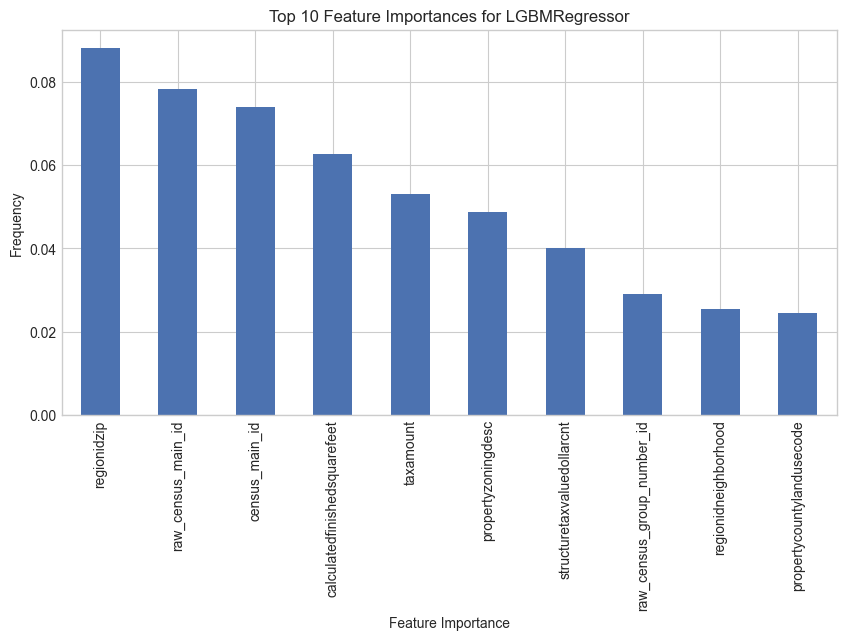

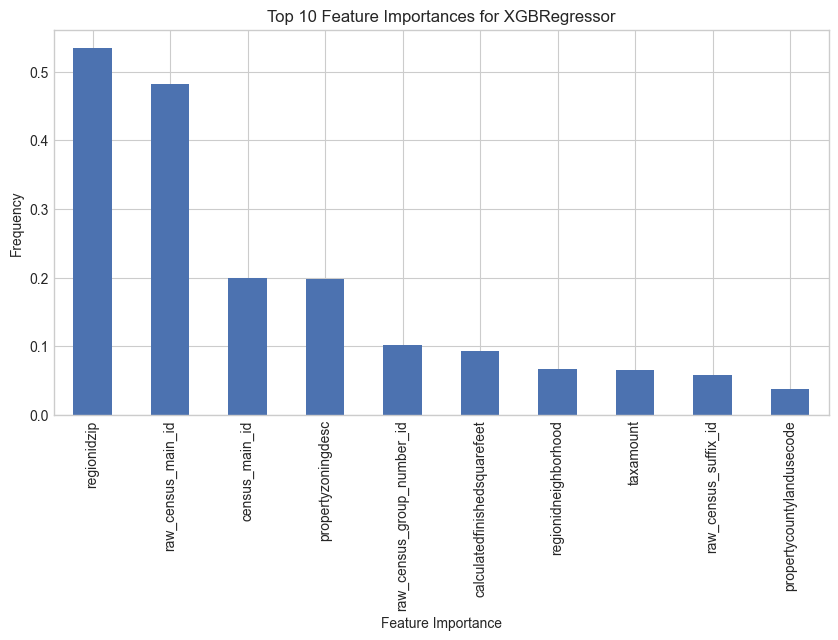

['propertycountylandusecode', 'raw_census_main_id', 'regionidzip', 'propertyzoningdesc', 'raw_census_group_number_id', 'calculatedfinishedsquarefeet', 'regionidneighborhood', 'taxamount', 'census_main_id']


In [ ]:
perm_feats_per_model = []

for model_title in perm_importances_df.columns:
    fig, ax = plt.subplots(figsize=(10, 5))
    best = perm_importances_df[model_title].sort_values(ascending=False).head(cfg.n_top_cols)
    best.plot(kind='bar', ax=ax)
    perm_feats_per_model.append(best.index.tolist())
    plt.title(f"Top {cfg.n_top_cols} Feature Importances for {model_title}")
    plt.xlabel("Feature Importance")
    plt.ylabel("Frequency")
    plt.show()

print(find_shared_cols(*perm_feats_per_model))


### Results

In [ ]:
print(find_shared_cols(*model_feats_per_model, *perm_feats_per_model))

['raw_census_main_id', 'regionidzip', 'census_main_id']
